Необходимо создать, обучить нейронную сеть с точностью не менее 85% и упаковать её в архив для загрузки на демо-панель:
* создать нейронную сеть для распознавания марки автомобиля из 3х вариантов
* сохраните веса
* подготовить запуск модели "из коробки"
* подготовить архив с готовой нейронной сетью для загрузки в демо-панель


In [ ]:
# Сеть прямого распространения
from tensorflow.keras.models import Sequential

# Базовые слои для свёрточных сетей
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# Работа с изображениями
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Используем для to_categoricall
from tensorflow.keras import utils

# Для отрисовки изображений
from tensorflow.keras.preprocessing import image

# Библиотека работы с массивами
import numpy as np

# Для отрисовки графиков
import matplotlib.pyplot as plt

# Для отрисовки изображений
from PIL import Image

# Для генерации случайных чисел
import random

# Для округления
import math

# Для работы с файлами
import os

## Распознавание марок машин

In [ ]:
import gdown

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l5/middle_fmr.zip', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l6/car_test.zip', None, quiet=True)

'car_test.zip'

In [ ]:
!unzip -q middle_fmr.zip -d /content/cars # Указываем путь к базе в Google Drive

In [ ]:
classes = sorted(os.listdir('cars'))
print(classes)

['Mercedes', 'Ferrari', 'Renault']


In [ ]:
train_path = '/content/cars' # Папка с папками картинок, рассортированных по категориям
batch_size = 10  # Размер выборки
img_width = 288  # Ширина изображения
img_height = 162 # Высота изображения

In [ ]:
# Генератор изображений

datagen = ImageDataGenerator(
    rescale=1. / 255,       # Значения цвета меняем на дробные показания
    rotation_range=10,      # Поворачиваем изображения при генерации выборки
    width_shift_range=0.1,  # Двигаем изображения по ширине при генерации выборки
    height_shift_range=0.1, # Двигаем изображения по высоте при генерации выборки
    zoom_range=0.1,         # Зумируем изображения при генерации выборки
    horizontal_flip=True,   # Отключаем отзеркаливание изображений
    fill_mode='nearest',    # Заполнение пикселей вне границ ввода
    validation_split=0.2    # Указываем разделение изображений на обучающую и тестовую выборку
)

In [ ]:
# Обучающая выборка

train_generator = datagen.flow_from_directory(
    train_path,                          # Путь ко всей выборке выборке
    target_size=(img_height, img_width), # Размер изображений
    batch_size=batch_size,               # Размер batch_size
    class_mode='categorical',            # Категориальный тип выборки. Разбиение выборки по маркам авто
    shuffle=True,                        # Перемешивание выборки
    subset='training'                    # устанавливаем как набор для обучения
)

# Проверочная выборка

validation_generator = datagen.flow_from_directory(
    train_path,                          # Путь ко всей выборке выборке
    target_size=(img_height, img_width), # Размер изображений
    batch_size=batch_size,               # Размер batch_size
    class_mode='categorical',            # Категориальный тип выборки. Разбиение выборки по маркам авто
    shuffle=True,                        # Перемешивание выборки
    subset='validation'                  # Устанавливаем как валидационный набор
)

Found 2743 images belonging to 3 classes.
Found 684 images belonging to 3 classes.


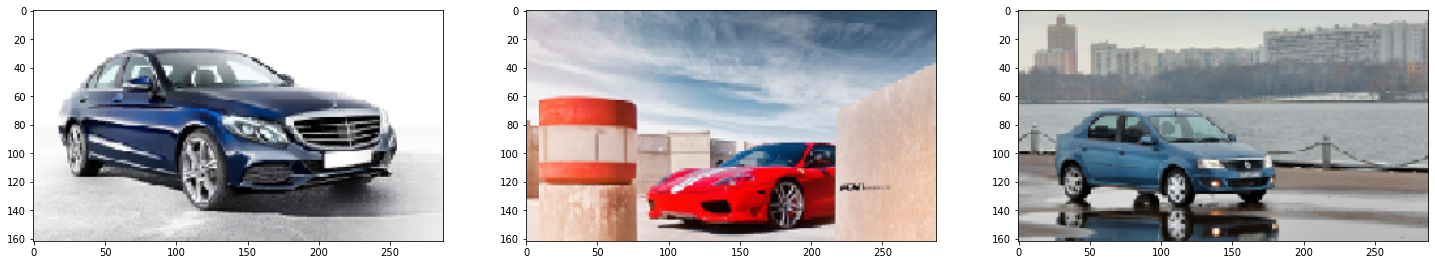

In [ ]:
# Выводим для примера картинки по каждому классу

fig, axs = plt.subplots(1, 3, figsize=(25, 5)) # Создаем полотно из 3 графиков

for i in range(3):                             # Проходим по всем классам
  car_path = train_path + '/' + os.listdir(train_path)[i] + '/' # Формируем путь к выборке
  img_path = car_path + random.choice(os.listdir(car_path))     # Выбираем случайное фото для отображения
  axs[i].imshow(image.load_img(img_path, target_size=(img_height, img_width))) # Отображение фотографии

plt.show() # Выводим изображения

In [ ]:
# Создаем последовательную модель

model = Sequential()

model.add(Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(img_width, img_height, 3))) # Сверточный слой
model.add(Conv2D(256, (3, 3), padding='same', activation='relu')) # Сверточный слой
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) # Сверточный слой
model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) # Сверточный слой
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) # Сверточный слой
model.add(Dropout(0.3)) # Слой регуляризации Dropout
model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) # Сверточный слой
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Dropout(0.3)) # Слой регуляризации Dropout

model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) # Сверточный слой
model.add(Conv2D(1024, (3, 3), padding='same', activation='relu')) ## Сверточный слой
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Dropout(0.3)) # Слой регуляризации Dropout

model.add(Flatten()) # Слой преобразования двумерных данных в одномерные

model.add(Dense(2048, activation='elu')) # Полносвязный слой
model.add(Dense(4096, activation='elu')) # Полносвязный слой

model.add(Dense(len(train_generator.class_indices), activation='softmax')) # Вызодной полносвязный слой

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs=60,
    verbose=1
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
274/274 [==============================] - 65s 235ms/step - loss: 1.0244 - accuracy: 0.4413 - val_loss: 1.1099 - val_accuracy: 0.3353
Epoch 2/60
274/274 [==============================] - 65s 235ms/step - loss: 0.9597 - accuracy: 0.5112 - val_loss: 0.9565 - val_accuracy: 0.4912
Epoch 3/60
274/274 [==============================] - 65s 236ms/step - loss: 0.9141 - accuracy: 0.5507 - val_loss: 1.0130 - val_accuracy: 0.4926
Epoch 4/60
274/274 [==============================] - 65s 237ms/step - loss: 0.8469 - accuracy: 0.6070 - val_loss: 0.9111 - val_accuracy: 0.5765
Epoch 5/60
274/274 [==============================] - 65s 236ms/step - loss: 0.8413 - accuracy: 0.6070 - val_loss: 0.9146 - val_accuracy: 0.5985
Epoch 6/60
274/274 [==============================] - 65s 236ms/step - loss: 0.7996 - accuracy: 0.6308 - val_loss: 0.8941 - val_accuracy: 0.5529
Epoch 7/60
274/274 [==============================] - 64s 235ms/step - loss: 0.7672 - accuracy: 0.6634 - val_loss: 0.8776 - val_ac

In [ ]:
# Дообучаем модель ещё на 50 эпохах с уменьшенным шагом
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs=50,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


274/274 [==============================] - 65s 235ms/step - loss: 0.0257 - accuracy: 0.9923 - val_loss: 0.6569 - val_accuracy: 0.8412
Epoch 2/50
274/274 [==============================] - 65s 235ms/step - loss: 0.0088 - accuracy: 0.9982 - val_loss: 0.6941 - val_accuracy: 0.8471
Epoch 3/50
274/274 [==============================] - 65s 236ms/step - loss: 0.0067 - accuracy: 0.9989 - val_loss: 0.7308 - val_accuracy: 0.8368
Epoch 4/50
274/274 [==============================] - 64s 235ms/step - loss: 0.0046 - accuracy: 0.9989 - val_loss: 0.6578 - val_accuracy: 0.8588
Epoch 5/50
274/274 [==============================] - 65s 235ms/step - loss: 0.0071 - accuracy: 0.9982 - val_loss: 0.7372 - val_accuracy: 0.8441
Epoch 6/50
274/274 [==============================] - 64s 235ms/step - loss: 0.0076 - accuracy: 0.9985 - val_loss: 0.7584 - val_accuracy: 0.8515
Epoch 7/50
274/274 [==============================] - 64s 234ms/step - loss: 0.0053 - accuracy: 0.9978 - val_loss: 0.7805 - val_accuracy: 0.8

In [ ]:
# Дообучаем модель ещё на 20 эпохах с уменьшенным шагом
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.000001), metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs=20,
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


274/274 [==============================] - 65s 236ms/step - loss: 0.0027 - accuracy: 0.9989 - val_loss: 1.0530 - val_accuracy: 0.8647
Epoch 2/20
274/274 [==============================] - 64s 234ms/step - loss: 2.4030e-04 - accuracy: 1.0000 - val_loss: 1.0910 - val_accuracy: 0.8691
Epoch 3/20
274/274 [==============================] - 64s 234ms/step - loss: 3.6684e-04 - accuracy: 1.0000 - val_loss: 1.0807 - val_accuracy: 0.8632
Epoch 4/20
274/274 [==============================] - 65s 235ms/step - loss: 0.0052 - accuracy: 0.9989 - val_loss: 0.9866 - val_accuracy: 0.8750
Epoch 5/20
274/274 [==============================] - 64s 234ms/step - loss: 0.0037 - accuracy: 0.9996 - val_loss: 1.0947 - val_accuracy: 0.8691
Epoch 6/20
274/274 [==============================] - 64s 235ms/step - loss: 0.0015 - accuracy: 0.9989 - val_loss: 1.0752 - val_accuracy: 0.8603
Epoch 7/20
274/274 [==============================] - 65s 236ms/step - loss: 0.0031 - accuracy: 0.9989 - val_loss: 1.1162 - val_accur

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 288, 162, 256)     7168      
                                                                 
 conv2d_1 (Conv2D)           (None, 288, 162, 256)     590080    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 54, 256)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 54, 512)       1180160   
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 54, 512)       2359808   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 18, 512)      0         
 2D)                                                    

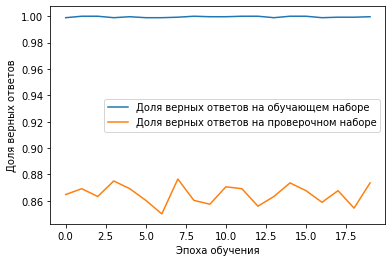

In [ ]:
# Отображаем график точности обучения

plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
model.save('model_fmr_all.h5')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model_fmr_all.h5')

In [ ]:
!unzip -q car_test.zip

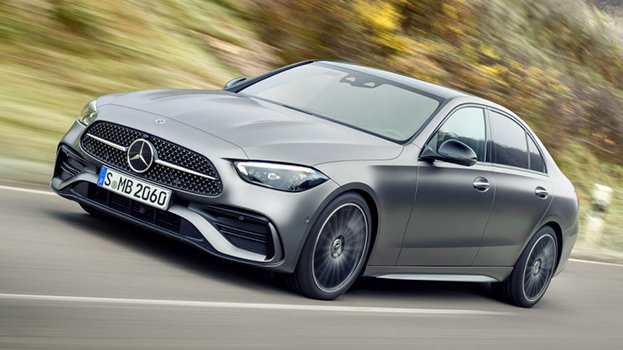

In [ ]:
from PIL import Image

test_path = '/content/car_test/5.jpg'
img_width, img_height = img_width, img_height
img = Image.open(test_path)

display(img)

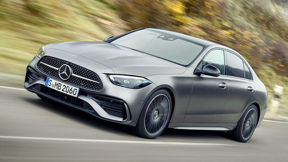

Результат распознавания:
Ferrari       0.0%
Mercedes      100.0%
Renault       0.0%

Изображен(а):  Mercedes


In [ ]:
import numpy as np

img = Image.open(test_path).resize((img_width, img_height))
display(img)

image = np.array(img, dtype='float64') / 255
image = image.reshape(-1, img_height, img_width, 3)

pred = model.predict(image)
print('Результат распознавания:')

for i, cl in enumerate(classes):
    print(cl.ljust(14), round(100* pred[0][i], 2), '%', sep='')

print()
cls_image = np.argmax(model.predict(image))
print('Изображен(а): ', classes[cls_image])

In [ ]:
def predict(img_path='./test_image_1.jpg', model_path='./model_fmr_all.h5'):

    from tensorflow.keras.models import load_model

    model = load_model(model_path)

    img_width, img_height = 288, 162

    img = Image.open(test_path).resize((img_width, img_height))
    display(img)

    image = np.array(img, dtype='float64') / 255
    image = image.reshape(-1, img_height, img_width, 3)

    cls_image = np.argmax(model.predict(image))

    print(cls_image)

In [ ]:
text_code = '''
from PIL import Image
import numpy as np

def predict(img_path='./test_image_1.jpg', model_path='./model_fmr_all.h5'):

    from tensorflow.keras.models import load_model

    model = load_model(model_path)

    img_width, img_height = 288, 162

    img = Image.open(test_path).resize((img_width, img_height)) # Изменение размерности для соответсвия входному слою
    display(img)

    image = np.array(img, dtype='float64') / 255  # нормализация
    image = image.reshape(-1, img_height, img_width, 3)

    cls_image = np.argmax(model.predict(image))

    print(cls_image)

'''

with open('script.py', 'w') as f:
  f.write(text_code)

In [ ]:
from shutil import copyfile

for i in os.listdir('/content/car_test/'):
    copyfile('/content/car_test/'+i, '/content/'+i)

In [ ]:
label_txt = '''

Ferrari
Mersedes
Renault

'''

with open('label.txt', 'w') as f:
  f.write(label_txt.strip())

In [ ]:
import os
integrate_files = ['model_fmr_all.h5', 'script.py', 'label.txt', *[f'{i}.jpg' for i in range(10)]]

from zipfile import ZipFile as Zip

zipArchive = Zip('/content/archive.zip', 'w')

for file in integrate_files:
  if os.path.exists(file):
    zipArchive.write(file)
  else:
    print(f'Файл {file} отсутствует!')

zipArchive.close()

In [ ]:
from google.colab import files

files.download(filename='archive.zip')

print('Архив загружен')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Архив загружен
